# Business Context:
An e-commerce platform observes high user engagement but low purchase completion. Management wants to understand:

- Where users drop off in the funnel
- Which products attract attention but fail to convert
- How funnel performance changes over time
- What actions can improve revenue

**Goal:** To Identify the conversion bottlenecks and revenue leakage points across the user journey: View → Add to Cart → Purchase

# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data load and insights

In [2]:
df = pd.read_csv('Dataset/ecommerce_events_history.csv')
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

- user_id → unique user identifier
- event_type → type of event: view_product, add_to_cart, purchase, remove_from_cart
- event_time → timestamp
- product_id → product identifier
- category_id → product category
- brand → product brand
- price → product price
- category_code → Standardized code for product category
- user_session → Unique identifier for each user session

In [3]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


In [4]:
df.dtypes

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

In [5]:
df[['event_time','event_type','user_id','price']].isnull().sum()

event_time    0
event_type    0
user_id       0
price         0
dtype: int64

In [6]:
# timestamp to date time
df['event_time'] = pd.to_datetime(df['event_time'])

df = df[df['event_type'].isin(['view', 'cart', 'purchase'])]

# Funnel metrics

In [7]:
views = df[df['event_type'] == 'view']['user_id'].nunique()
carts = df[df['event_type'] == 'cart']['user_id'].nunique()
purchases = df[df['event_type'] == 'purchase']['user_id'].nunique()

funnel = pd.DataFrame({
    'Stage': ['View', 'Add to Cart', 'Purchase'],
    'Users': [views, carts, purchases]
})

print(f"Top (views): {views}, Middle (add to cart): {carts}, Bottom (purchase): {purchases}")
print(f"Drop in view -> cart: {(views - carts)/views*100:.2f}%")
print(f"Drop in cart -> purchase: {(carts - purchases)/carts*100:.2f}%")

Top (views): 358212, Middle (add to cart): 83458, Bottom (purchase): 25613
Drop in view -> cart: 76.70%
Drop in cart -> purchase: 69.31%


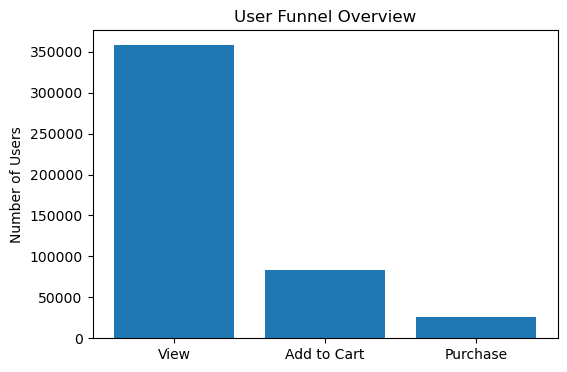

In [8]:
# plot
plt.figure(figsize=(6,4))
plt.bar(funnel['Stage'], funnel['Users'])
plt.title('User Funnel Overview')
plt.ylabel('Number of Users')
plt.show()

The funnel analysis reveals a progressive reduction in user counts at each stage of the purchasing journey. Out of 358,212 users who viewed at least one product, 83,458 proceeded to add a product to their cart, and 25,613 ultimately completed a purchase. This corresponds to a 76.70% drop-off between the view and add-to-cart stages, followed by a 69.31% drop-off between the add-to-cart and purchase stages. These figures indicate that a substantial proportion of users disengage before advancing to the next funnel stage, highlighting clear transition points where user progression decreases significantly.

# Product Level Conversion Analysis

In [9]:
top_views = df[df['event_type'] == 'view']['product_id'].value_counts().head(10)

top_purchases = (
    df[df['event_type'] == 'purchase']['product_id']
    .value_counts()
    .reindex(top_views.index)
    .fillna(0)
)

product_funnel = pd.DataFrame({
    'Views': top_views,
    'Purchases': top_purchases
})

product_funnel['Conversion Rate (%)'] = (
    product_funnel['Purchases'] / product_funnel['Views'] * 100
)

product_funnel.sort_values('Conversion Rate (%)', ascending=False)


,Views,Purchases,Conversion Rate (%)
product_id,,,
5809912,5944,620,10.430686
5809911,4307,386,8.962155
5809910,24419,1659,6.793890
5649236,4372,148,3.385178
5909810,8473,231,2.726307
5886282,5488,90,1.639942
5877454,6621,101,1.525449
5856186,4015,42,1.046077
5769877,4100,27,0.658537


Top viewed products show notable differences in conversion efficiency. Product 5809910 has the highest views which is more than 24k but a modest conversion rate (6.8%), while products 5809912 and 5809911 achieve higher conversion rates of 10.4% and 9% with fewer views. This indicates that high visibility does not always lead to more purchases, and several products fall below 2% conversion, highlighting uneven performance and the need to consider both engagement and purchase efficiency.

# User Behavior insights

In [10]:
user_event_count = df.groupby('user_id')['event_type'].nunique()

repeat_users = (user_event_count > 1).sum()
single_event_users = (user_event_count == 1).sum()

print(f"Repeat users: {repeat_users}")
print(f"Single-event users: {single_event_users}")


Repeat users: 74120
Single-event users: 295332


# Time Based Funnel

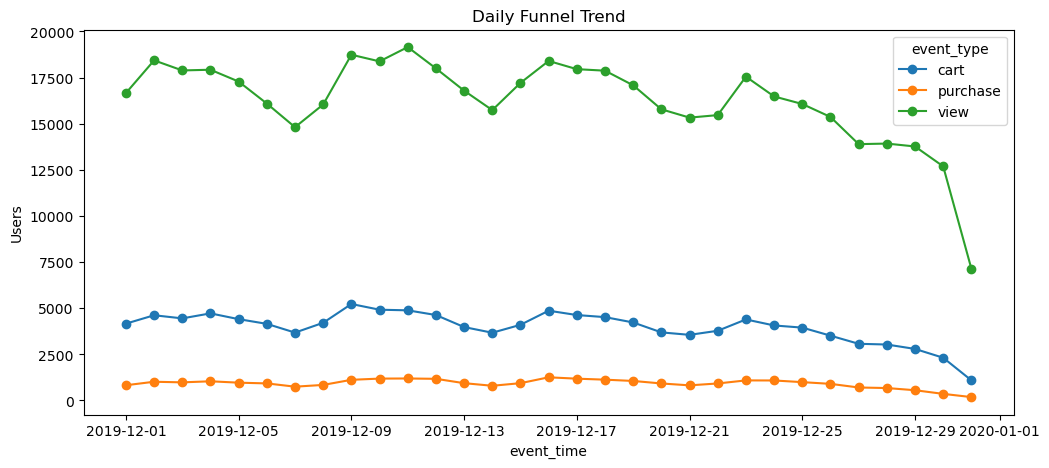

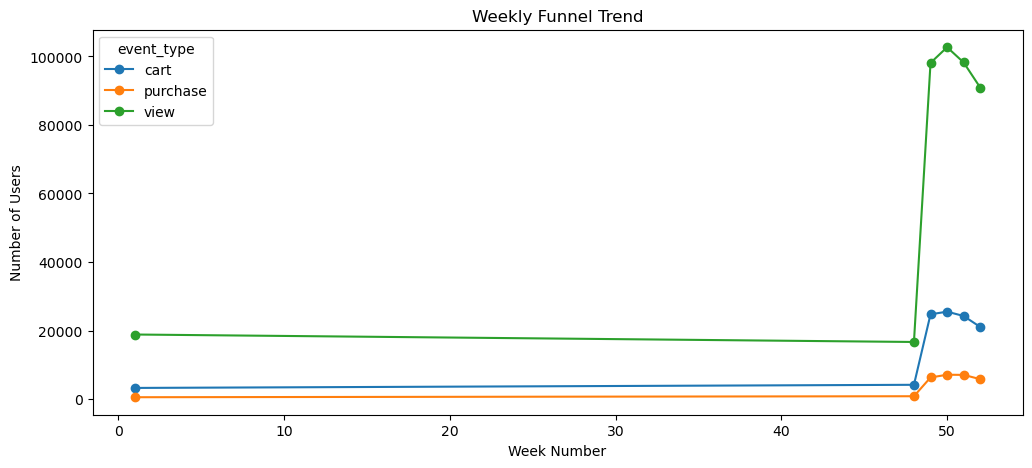

In [11]:
# daily
daily_funnel = df.groupby(
    [df['event_time'].dt.date, 'event_type']
)['user_id'].nunique().unstack().fillna(0)

daily_funnel.plot(figsize=(12,5), marker='o')
plt.title('Daily Funnel Trend')
plt.ylabel('Users')
plt.show()
#weekly
df['week'] = df['event_time'].dt.isocalendar().week
weekly_funnel = df.groupby(['week', 'event_type'])['user_id'].nunique().unstack().fillna(0)
weekly_funnel.plot(figsize=(12,5), marker='o')
plt.title('Weekly Funnel Trend')
plt.xlabel('Week Number')
plt.ylabel('Number of Users')
plt.show()



**Daily Funnel Trend :**
From December 1, 2019, to January 1, 2020, the e-commerce funnel shows a clear hierarchy with Views at the top (~12.5k–19.5k/day), followed by Cart and Purchase  at the bottom (below 2k/day). A sharp decline across all events occurs on December 30–31, likely due to holiday effects, the end of a campaign, or a tracking issue. The data also exhibits recurring peaks every 5–7 days, indicating possible day-of-week traffic patterns. Despite these fluctuations, the conversion ratios (Cart/View and Purchase/Cart) remain relatively stable, suggesting that the funnel’s efficiency stayed consistent throughout the month.

**Weekly Funnel Trend :** Analysis of weekly funnel activity over the year reveals, weeks 1–48 show a very low and flat baseline of activity, with Views hovering around ~20,000 per week and Cart and Purchase volumes minimal purchases are near zero. In contrast, Weeks 49–52 experience a dramatic spike, with Views surging past 100,000 per week and Cart/Purchase volumes increasing proportionally, reflecting major holiday-driven shopping (e.g., Black Friday, Cyber Monday, Christmas). Despite this massive surge, the relative distance between Views, Cart, and Purchase lines remains consistent, indicating stable conversion efficiency even under extreme load. Overall, the business is highly seasonal, with nearly all engagement and sales concentrated in the final promotional weeks, while the remainder of the year operates at a minimal baseline.


# Some Overall Insights
- Many users drop off between view and cart, showing products aren’t convincing enough.
- Another big drop happens between cart and purchase, pointing to checkout or pricing issues.
- Some popular products still don’t sell well, losing potential revenue.
- Most users only visit once, meaning retention is low.


# Potential Revenue

In [12]:
avg_price = df[(df['event_type'] == 'purchase') & (df['price'] > 0)]['price'].mean()

Average purchase price was calculated using only positive purchase values to reflect realized sales revenue, excluding refunds and reversals

In [13]:

# Actual revenue
actual_revenue = purchases * avg_price
# Potential revenue if all cart users purchased
potential_revenue_cart = carts * avg_price
# Potential revenue if all viewers purchased
potential_revenue_view = views * avg_price


# Revenue loss
lost_revenue_cart_stage = potential_revenue_cart - actual_revenue
lost_revenue_view_stage = potential_revenue_view - actual_revenue
print(f"Average purchase price: ${avg_price:,.2f}")
print(f"Actual revenue: ${actual_revenue:,.2f}")
print(f"Potential revenue (Cart stage): ${potential_revenue_cart:,.2f}")
print(f"Revenue lost after Cart stage: ${lost_revenue_cart_stage:,.2f}")
print(f"Revenue lost after View stage: ${lost_revenue_view_stage:,.2f}")



Average purchase price: $5.06
Actual revenue: $129,551.92
Potential revenue (Cart stage): $422,135.01
Revenue lost after Cart stage: $292,583.09
Revenue lost after View stage: $1,682,303.48


## Suggetions
- Make product pages better for items with lots of views but few purchases.
- Add limited time discounts or trust badges to encourage buying.
- Simplify the checkout process to reduce dropoffs.
- A/B test CTA buttons and pricing displays to find what works best.
- Optimize product recommendation engine to surface highly relevant items, driving more sell opportunities
- Remind users who leave items in their cart via emails or ads.

In [14]:
df.to_csv('Dataset/ecommerce_events_history_cleaned.csv')